# Uber Trip Data Regression
-----
In this notebook I will be using a regression model against a dataset regarding upber trips.

The purpose of this model is to predict the __fare price__ given various ride features.

----------
*Data from: https://www.kaggle.com/yasserh/uber-fares-dataset*

In [1]:
# Importing required libraries

## Data processing
import pandas as pd
import numpy as np
import datetime
from geopy.distance import geodesic # Required to calculate distance between long/lat cooridinates of:
                                    # pickup & dropoff points

# Data viz
import matplotlib.pyplot as plt
import seaborn as sn

## SkLearn packages 
from sklearn import linear_model # Linear regression model
from sklearn.ensemble import RandomForestRegressor # Random forest regressor
from sklearn.model_selection import train_test_split # To split the data into training and testing sets

In [2]:
# Import our data
df = pd.read_csv(r"C:\Users\ssc44611\Documents\L4 Projects\4. ML Practice Projects\Uber Regression\uber.csv")
df.head()

,Unnamed: 0,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,24238194,2015-05-07 19:52:06.0000003,7.5,2015-05-07 19:52:06 UTC,-73.999817,40.738354,-73.999512,40.723217,1
1,27835199,2009-07-17 20:04:56.0000002,7.7,2009-07-17 20:04:56 UTC,-73.994355,40.728225,-73.994710,40.750325,1
2,44984355,2009-08-24 21:45:00.00000061,12.9,2009-08-24 21:45:00 UTC,-74.005043,40.740770,-73.962565,40.772647,1
3,25894730,2009-06-26 08:22:21.0000001,5.3,2009-06-26 08:22:21 UTC,-73.976124,40.790844,-73.965316,40.803349,3
4,17610152,2014-08-28 17:47:00.000000188,16.0,2014-08-28 17:47:00 UTC,-73.925023,40.744085,-73.973082,40.761247,5


In [3]:
# Shape of our DF
df.shape

(200000, 9)

### Brain dump for this task:

Our __feature__ column will be:
- *pickup_datetime*
- *pickup_longitude*
- *pickup_latitude*
- *dropoff_longitude*
- *dropoff_latitude*
- *passenger_count*

Our __target__ column will be:
- *fare_amount*

__*The features used may be changed later on in the notebook*__

## Data procesisng (initial)

In [4]:
# Looking for null values
df.isnull().sum()

Unnamed: 0           0
key                  0
fare_amount          0
pickup_datetime      0
pickup_longitude     0
pickup_latitude      0
dropoff_longitude    1
dropoff_latitude     1
passenger_count      0
dtype: int64

There are __two columns with null values__, let's just drop these rows that are missng values, because;
1) If ammended or overwritted to 0, this may have an effect on the model

2) One or two rows missing from a df of 200,000 won't effect the end model performance

From point __1__, we will need to find any rows with coordinates of 0

In [5]:
# Locating any rows that have no coordinates for either of the pickup/dropoff columns 
df.loc[( (df['pickup_longitude'] == 0) | (df['pickup_latitude'] == 0) | (df['dropoff_longitude'] == 0) | (df['dropoff_latitude'] == 0) ) | (df['pickup_longitude'] == 'nan') | (df['pickup_latitude'] == 'nan') | (df['dropoff_longitude'] == 'nan') | (df['dropoff_latitude'] == 'nan') |
      (df['pickup_longitude'] == 0.0) | (df['pickup_latitude'] == 0.0) | (df['dropoff_longitude'] == 0.0) | (df['dropoff_latitude'] == 0.0)].shape

(3968, 9)

In [6]:
# Storing index of rows with no coordinates - to drop; .index
no_coordinates = df.loc[( (df['pickup_longitude'] == 0) | (df['pickup_latitude'] == 0) | (df['dropoff_longitude'] == 0) | (df['dropoff_latitude'] == 0) )].index

We have __3968 rows__ that have a longitude and latitude of 0, but aren't referenced as null coordinates. 
- We will need to drop these rows, as the geolocation of the ride is an important factor of the ride fare

In [7]:
# Storing index of rows with null values - to drop; .index
df.dropna()

,Unnamed: 0,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,24238194,2015-05-07 19:52:06.0000003,7.5,2015-05-07 19:52:06 UTC,-73.999817,40.738354,-73.999512,40.723217,1
1,27835199,2009-07-17 20:04:56.0000002,7.7,2009-07-17 20:04:56 UTC,-73.994355,40.728225,-73.994710,40.750325,1
2,44984355,2009-08-24 21:45:00.00000061,12.9,2009-08-24 21:45:00 UTC,-74.005043,40.740770,-73.962565,40.772647,1
3,25894730,2009-06-26 08:22:21.0000001,5.3,2009-06-26 08:22:21 UTC,-73.976124,40.790844,-73.965316,40.803349,3
4,17610152,2014-08-28 17:47:00.000000188,16.0,2014-08-28 17:47:00 UTC,-73.925023,40.744085,-73.973082,40.761247,5
...,...,...,...,...,...,...,...,...,...
199995,42598914,2012-10-28 10:49:00.00000053,3.0,2012-10-28 10:49:00 UTC,-73.987042,40.739367,-73.986525,40.740297,1
199996,16382965,2014-03-14 01:09:00.0000008,7.5,2014-03-14 01:09:00 UTC,-73.984722,40.736837,-74.006672,40.739620,1
199997,27804658,2009-06-29 00:42:00.00000078,30.9,2009-06-29 00:42:00 UTC,-73.986017,40.756487,-73.858957,40.692588,2
199998,20259894,2015-05-20 14:56:25.0000004,14.5,2015-05-20 14:56:25 UTC,-73.997124,40.725452,-73.983215,40.695415,1


The row with null values for both; "dropoff_longitude" and "dropoff_latitude", has been located - we can drop it accordingly.

In [8]:
# Dropping rows that are: null and have coordinates of 0
df.drop(no_coordinates) # dropping rows with no coordinates

,Unnamed: 0,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,24238194,2015-05-07 19:52:06.0000003,7.5,2015-05-07 19:52:06 UTC,-73.999817,40.738354,-73.999512,40.723217,1
1,27835199,2009-07-17 20:04:56.0000002,7.7,2009-07-17 20:04:56 UTC,-73.994355,40.728225,-73.994710,40.750325,1
2,44984355,2009-08-24 21:45:00.00000061,12.9,2009-08-24 21:45:00 UTC,-74.005043,40.740770,-73.962565,40.772647,1
3,25894730,2009-06-26 08:22:21.0000001,5.3,2009-06-26 08:22:21 UTC,-73.976124,40.790844,-73.965316,40.803349,3
4,17610152,2014-08-28 17:47:00.000000188,16.0,2014-08-28 17:47:00 UTC,-73.925023,40.744085,-73.973082,40.761247,5
...,...,...,...,...,...,...,...,...,...
199995,42598914,2012-10-28 10:49:00.00000053,3.0,2012-10-28 10:49:00 UTC,-73.987042,40.739367,-73.986525,40.740297,1
199996,16382965,2014-03-14 01:09:00.0000008,7.5,2014-03-14 01:09:00 UTC,-73.984722,40.736837,-74.006672,40.739620,1
199997,27804658,2009-06-29 00:42:00.00000078,30.9,2009-06-29 00:42:00 UTC,-73.986017,40.756487,-73.858957,40.692588,2
199998,20259894,2015-05-20 14:56:25.0000004,14.5,2015-05-20 14:56:25 UTC,-73.997124,40.725452,-73.983215,40.695415,1


In [9]:
# As we're not using cols: Unnamed: 0 & key, we can drop it
cols_to_drop = ['key', 'Unnamed: 0']
df.drop(cols_to_drop, axis='columns')

,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,7.5,2015-05-07 19:52:06 UTC,-73.999817,40.738354,-73.999512,40.723217,1
1,7.7,2009-07-17 20:04:56 UTC,-73.994355,40.728225,-73.994710,40.750325,1
2,12.9,2009-08-24 21:45:00 UTC,-74.005043,40.740770,-73.962565,40.772647,1
3,5.3,2009-06-26 08:22:21 UTC,-73.976124,40.790844,-73.965316,40.803349,3
4,16.0,2014-08-28 17:47:00 UTC,-73.925023,40.744085,-73.973082,40.761247,5
...,...,...,...,...,...,...,...
199995,3.0,2012-10-28 10:49:00 UTC,-73.987042,40.739367,-73.986525,40.740297,1
199996,7.5,2014-03-14 01:09:00 UTC,-73.984722,40.736837,-74.006672,40.739620,1
199997,30.9,2009-06-29 00:42:00 UTC,-73.986017,40.756487,-73.858957,40.692588,2
199998,14.5,2015-05-20 14:56:25 UTC,-73.997124,40.725452,-73.983215,40.695415,1


In [10]:
# Converting the date columns to have just the time
df['pickup_datetime'] = pd.to_datetime(df["pickup_datetime"]) # Converting our date/time column to DateTime dtype
df['pickup_datetime'] = df['pickup_datetime'].dt.time # We just want the time, 
                                                      # as the data won't influence price like the time will

In [11]:
# Need a duplicate column of the time column, this is so we can plot/use this data in a loop.
## As a dtype of DateTime, we can't use the values for some functions.
df['pickup_datetime_str'] = df['pickup_datetime'].astype(str)
df['pickup_datetime_str']

0         19:52:06
1         20:04:56
2         21:45:00
3         08:22:21
4         17:47:00
            ...   
199995    10:49:00
199996    01:09:00
199997    00:42:00
199998    14:56:25
199999    04:08:00
Name: pickup_datetime_str, Length: 200000, dtype: object

In [12]:
df.head()

,Unnamed: 0,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,pickup_datetime_str
0,24238194,2015-05-07 19:52:06.0000003,7.5,19:52:06,-73.999817,40.738354,-73.999512,40.723217,1,19:52:06
1,27835199,2009-07-17 20:04:56.0000002,7.7,20:04:56,-73.994355,40.728225,-73.994710,40.750325,1,20:04:56
2,44984355,2009-08-24 21:45:00.00000061,12.9,21:45:00,-74.005043,40.740770,-73.962565,40.772647,1,21:45:00
3,25894730,2009-06-26 08:22:21.0000001,5.3,08:22:21,-73.976124,40.790844,-73.965316,40.803349,3,08:22:21
4,17610152,2014-08-28 17:47:00.000000188,16.0,17:47:00,-73.925023,40.744085,-73.973082,40.761247,5,17:47:00


#### Look for any coordinates that are:
- Less than -90 
- Greater than 90

We need to locate these rows, and then drop them accordingly.

In [13]:
# Locate any row that has a latitude less than -90, this obviously doesn't make sense and needs to be dropped
less_minus_90 = df.loc[(df['pickup_latitude'] < -90) | (df['dropoff_latitude']  > 90)].index

# Drop this row(s)
df = df.drop(less_minus_90)

In [14]:
# Let's reset the index and drop the extra column as a product of the index reset
df.reset_index(drop=True, inplace=True)

In [15]:
df.head()

,Unnamed: 0,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,pickup_datetime_str
0,24238194,2015-05-07 19:52:06.0000003,7.5,19:52:06,-73.999817,40.738354,-73.999512,40.723217,1,19:52:06
1,27835199,2009-07-17 20:04:56.0000002,7.7,20:04:56,-73.994355,40.728225,-73.994710,40.750325,1,20:04:56
2,44984355,2009-08-24 21:45:00.00000061,12.9,21:45:00,-74.005043,40.740770,-73.962565,40.772647,1,21:45:00
3,25894730,2009-06-26 08:22:21.0000001,5.3,08:22:21,-73.976124,40.790844,-73.965316,40.803349,3,08:22:21
4,17610152,2014-08-28 17:47:00.000000188,16.0,17:47:00,-73.925023,40.744085,-73.973082,40.761247,5,17:47:00


### Calculating ride distance (pickup -> dropoff) - Geodesic

#### New columns: Calculated pickup to dropoff distance

We will create a loop that will interate through each index of the df.

In [16]:
# Empty variables, to append with the loop
ride_distance_mi = []
ride_distance_km = []

#### I'm just going to use 50000 samples, there's arrors in this data, that I don't know how to clean yet.

There are some rows (index > 50000) where their coordinates are wrong. 

In [17]:
for i in np.arange(0, 50000): # loop interates through the first 50k samples
    
    # Specifying pick up - lat/long
    pick_up_lat = df.pickup_latitude
    pick_up_long = df.pickup_longitude
    
    # Specifying drop off - lat/long
    drop_off_lat = df.dropoff_latitude
    drop_off_long = df.dropoff_longitude
    
    # Calculating distances - Miles/KM
    ## And appending to empty variables
    ride_distance_mi.append(geodesic((pick_up_lat[i], pick_up_long[i]), (drop_off_lat[i], drop_off_long[i])).miles)
    ride_distance_km.append(geodesic((pick_up_lat[i], pick_up_long[i]), (drop_off_lat[i], drop_off_long[i])).km)


Using __geopy - geodesic__, we calculated this distance between the origin (pickup) point and an end (dropoff) point.
- Syntax: __geodesic(*latitude*, *longitude*).*unit_of_measurement*__

In [18]:
len(ride_distance_mi)

50000

In [74]:
# Print our distances
ride_distance_mi[0:10]

[1.0445937861491572,
 1.5250706123331683,
 3.1314639281870544,
 1.0323719006396994,
 2.7860607099396897,
 0.0,
 7.291584115691231,
 0.0,
 1.4531136025314275,
 3.03920190901205]

Now that we've calculated this distance from the pickup location to the dropoff location in miles & kilometers, we can apply them to the df.

Since we have only 50k, we'll need to locate the first 50k values of out df and apply the distance values after this.

In [20]:
# First 50k values
df_50k = df.iloc[0:50000]
df_50k.head()

,Unnamed: 0,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,pickup_datetime_str
0,24238194,2015-05-07 19:52:06.0000003,7.5,19:52:06,-73.999817,40.738354,-73.999512,40.723217,1,19:52:06
1,27835199,2009-07-17 20:04:56.0000002,7.7,20:04:56,-73.994355,40.728225,-73.994710,40.750325,1,20:04:56
2,44984355,2009-08-24 21:45:00.00000061,12.9,21:45:00,-74.005043,40.740770,-73.962565,40.772647,1,21:45:00
3,25894730,2009-06-26 08:22:21.0000001,5.3,08:22:21,-73.976124,40.790844,-73.965316,40.803349,3,08:22:21
4,17610152,2014-08-28 17:47:00.000000188,16.0,17:47:00,-73.925023,40.744085,-73.973082,40.761247,5,17:47:00


In [21]:
# Placing mile and km outputs into seperate variables
df_new_mi = list(ride_distance_mi)
df_new_km = list(ride_distance_km)

In [22]:
# Creating a seperate df with the new calculated distances
## Append the distances to a new data frame
df_calc = pd.DataFrame(df_new_mi, columns=['Calculated Miles']) # Creating the new df
df_calc['Calculated KM'] = ride_distance_km # adding km distance as a new column

df_calc.head()

,Calculated Miles,Calculated KM
0,1.044594,1.681111
1,1.525071,2.454363
2,3.131464,5.039603
3,1.032372,1.661442
4,2.786061,4.483730


In [23]:
# Resetting indexes to concatenate the dfs
df_50k.reset_index(drop=True, inplace=True)
df_calc.reset_index(drop=True, inplace=True)

In [24]:
# Concatenating the two dfs:
    # 50k samples
    # Pickup/Dropoff distances
df_50k_calc = pd.concat([df_50k, df_calc], axis=1)
df_50k_calc.head()

,Unnamed: 0,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,pickup_datetime_str,Calculated Miles,Calculated KM
0,24238194,2015-05-07 19:52:06.0000003,7.5,19:52:06,-73.999817,40.738354,-73.999512,40.723217,1,19:52:06,1.044594,1.681111
1,27835199,2009-07-17 20:04:56.0000002,7.7,20:04:56,-73.994355,40.728225,-73.994710,40.750325,1,20:04:56,1.525071,2.454363
2,44984355,2009-08-24 21:45:00.00000061,12.9,21:45:00,-74.005043,40.740770,-73.962565,40.772647,1,21:45:00,3.131464,5.039603
3,25894730,2009-06-26 08:22:21.0000001,5.3,08:22:21,-73.976124,40.790844,-73.965316,40.803349,3,08:22:21,1.032372,1.661442
4,17610152,2014-08-28 17:47:00.000000188,16.0,17:47:00,-73.925023,40.744085,-73.973082,40.761247,5,17:47:00,2.786061,4.483730


As we've found the distance between the pickup and dropoff points, we can discard the following columns:
- Unnamed: 0
- Key
- pickup_longitude	
- pickup_latitude	
- dropoff_longitude	
- dropoff_latitude

In [25]:
# Dropping unnecessary columns
cols_to_drop_final = ['Unnamed: 0', 'key', 'pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude']
df_50k_calc.drop(cols_to_drop_final, axis = 1, inplace=True)

In [26]:
df_50k_calc.head()

,fare_amount,pickup_datetime,passenger_count,pickup_datetime_str,Calculated Miles,Calculated KM
0,7.5,19:52:06,1,19:52:06,1.044594,1.681111
1,7.7,20:04:56,1,20:04:56,1.525071,2.454363
2,12.9,21:45:00,1,21:45:00,3.131464,5.039603
3,5.3,08:22:21,3,08:22:21,1.032372,1.661442
4,16.0,17:47:00,5,17:47:00,2.786061,4.483730


__We now have a new dataframe; 50,000 samples conataining:__
- Ride distance
- Ride time
- Ride passangers
- Fare amount

Let's visualise with the new df that we've created.

## Data Visualisation (Further Processing)

Though we've processed the data, removing obvious anomalies or null data.

We should visualise our features and see if there are hidden anomalies.

### Passanger count

Text(0, 0.5, 'Fare Amount')

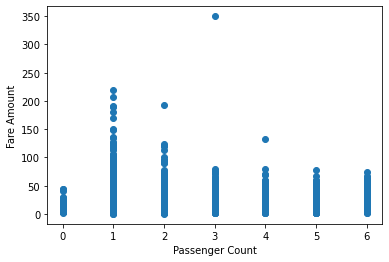

In [27]:
# Plotting passenger count agans fare amount
plt.scatter(df_50k_calc.passenger_count, df_50k_calc.fare_amount)

plt.xlabel('Passenger Count')
plt.ylabel('Fare Amount')

After plotting the passenger count against the fare amount, we can see a very obvious anomaly.
- There are one or more data points with a passanger count of 200+ - this should be impossible, unless Uber offer an airplane option
    - Let's drop however many rows fit this criteria
    
__*Issue isn't appearing now, but I'll keep these 2-3 cells just in case*__

In [28]:
# Dropping the anomalous 
anomaly_pass_count = df.loc[df['passenger_count'] >= 200].index
df = df.drop(anomaly_pass_count)

# Re run the passenger count/fare amount plot

Text(0, 0.5, 'Fare Amount')

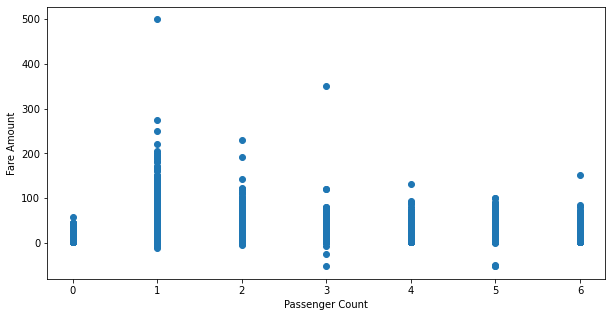

In [29]:
# Plotting passenger count agans fare amount
plt.figure(figsize=(10,5))

# Plot data
plt.scatter(df.passenger_count, df.fare_amount)

plt.xlabel('Passenger Count')
plt.ylabel('Fare Amount')

There isn't a clear trend between a higher passenger count = higher fare.
- This is kinda obvious the passenger count doesn't really effect the car's ability to move
    - There may've been a trend here if the primary transport was a bike/rickshaw/moped etc.


### Time of ride

In [30]:
# new df to have sorted time data
sorted_time_df = df_50k_calc.sort_values(by='pickup_datetime')
sorted_time_df.head()

,fare_amount,pickup_datetime,passenger_count,pickup_datetime_str,Calculated Miles,Calculated KM
18229,5.7,00:00:00,5,00:00:00,1.081746,1.740902
22331,14.5,00:00:00,1,00:00:00,4.774828,7.684340
31736,3.7,00:00:00,1,00:00:00,0.499700,0.804189
37915,6.2,00:00:00,1,00:00:00,0.973172,1.566168
10598,6.5,00:00:00,1,00:00:00,1.034294,1.664535


In [31]:
# The graph with the full 190k+ values takes too long to print, let's shorten it to the first 1000
sorted_time_df_1000 = sorted_time_df[0:1000]

Text(0, 0.5, 'Fare Amount')

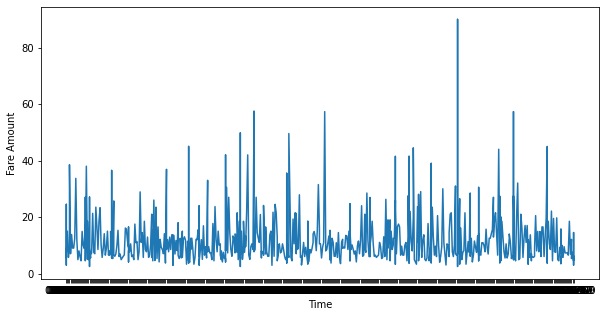

In [32]:
# Plotting passenger count agans fare amount 
plt.figure(figsize=(10,5))

# Plotting data
plt.plot(sorted_time_df_1000.pickup_datetime_str, sorted_time_df_1000.fare_amount)

# Graph labels
plt.xlabel('Time')
plt.ylabel('Fare Amount')

From the graph above, we can see that:
- The bottom line appears to be the same
- There are spikes of fare prices throughout the day, but nearing the end is where we see the large spikes
- There isn't a *clear* trend of different time = higher/less fare amount

### Miles

In [33]:
# Sorting and storing relevant data
sorted_distance_mi = df_50k_calc.sort_values(by='Calculated Miles')

In [34]:
sorted_distance_mi.tail()

,fare_amount,pickup_datetime,passenger_count,pickup_datetime_str,Calculated Miles,Calculated KM
30509,9.5,04:03:00,1,04:03:00,5387.571255,8670.455473
18887,58.0,01:48:45,1,01:48:45,5388.120425,8671.339277
40290,2.5,18:14:00,6,18:14:00,5388.559763,8672.046324
11530,2.5,08:10:00,1,08:10:00,5390.475125,8675.128799
34594,49.8,05:43:16,1,05:43:16,5453.660174,8776.815279


Text(0, 0.5, 'Fare Amount')

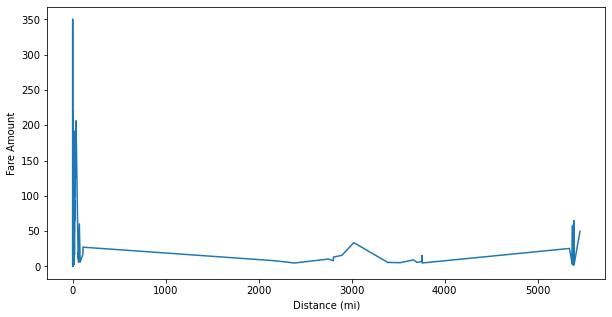

In [35]:
# Plotting ride distance and the fare amount
plt.figure(figsize=(10,5))

# Plot data
plt.plot(sorted_distance_mi['Calculated Miles'], sorted_distance_mi.fare_amount)

# Graph labels
plt.xlabel('Distance (mi)')
plt.ylabel('Fare Amount')

We can see that, after ~50/25mi the quality of the graph degrades, and I can't imagine there being many 100+ mile long journeys.

Let's drop any ride which has a ride distance > 100 - to see if there's a difference.

In [36]:
drop_extra_mi = sorted_distance_mi.loc[sorted_distance_mi['Calculated Miles'] > 17].index

In [37]:
# Dropping those rows
sorted_distance_mi.drop(drop_extra_mi, inplace=True)

# Reset index
sorted_distance_mi.reset_index(drop=True, inplace=True)

In [38]:
sorted_distance_mi

,fare_amount,pickup_datetime,passenger_count,pickup_datetime_str,Calculated Miles,Calculated KM
0,5.70,22:07:00,1,22:07:00,0.000000,0.000000
1,11.00,23:14:00,2,23:14:00,0.000000,0.000000
2,8.10,19:28:00,5,19:28:00,0.000000,0.000000
3,10.90,18:01:00,2,18:01:00,0.000000,0.000000
4,6.50,16:41:00,1,16:41:00,0.000000,0.000000
...,...,...,...,...,...,...
49846,49.15,15:52:11,1,15:52:11,16.210062,26.087566
49847,57.33,17:08:27,1,17:08:27,16.263947,26.174285
49848,43.70,12:42:30,1,12:42:30,16.322379,26.268323
49849,100.58,22:20:00,2,22:20:00,16.586442,26.693290


Text(0, 0.5, 'Fare Amount')

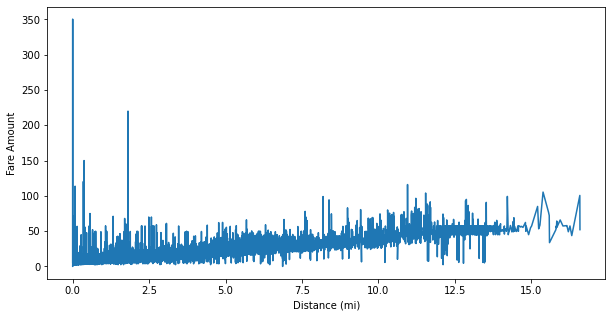

In [39]:
# Plotting ride distance and the fare amount
plt.figure(figsize=(10,5))

# Plot data
plt.plot(sorted_distance_mi['Calculated Miles'], sorted_distance_mi.fare_amount)

# Graph labels
plt.xlabel('Distance (mi)')
plt.ylabel('Fare Amount')

There's a semi-consistent linear relation between the distance (mi) and fare amount, up until ~15 miles (*I ammended the max distance in the cell above*)

Afer that, the quality of the plot drops

### Kilometers

In [40]:
# Sorting and storing relevant data
sorted_distance_km = df_50k_calc.sort_values(by='Calculated KM')

In [41]:
sorted_distance_km.head()

,fare_amount,pickup_datetime,passenger_count,pickup_datetime_str,Calculated Miles,Calculated KM
41186,5.7,22:07:00,1,22:07:00,0.0,0.0
45319,11.0,23:14:00,2,23:14:00,0.0,0.0
45318,8.1,19:28:00,5,19:28:00,0.0,0.0
32502,10.9,18:01:00,2,18:01:00,0.0,0.0
40602,6.5,16:41:00,1,16:41:00,0.0,0.0


Text(0, 0.5, 'Fare Amount')

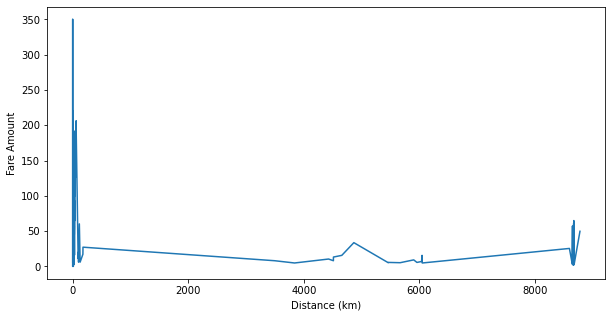

In [42]:
# Plotting ride distance and the fare amount
plt.figure(figsize=(10,5))

# Plot data
plt.plot(sorted_distance_km['Calculated KM'], sorted_distance_km.fare_amount)

# Graph labels
plt.xlabel('Distance (km)')
plt.ylabel('Fare Amount')

We can see that, after ~50/25km the quality of the graph degrades, and I can't imagine there being many 100+ mile long journeys.

Let's drop any ride which has a ride distance > 100 - to see if there's a difference.

In [43]:
drop_extra_km = sorted_distance_km.loc[sorted_distance_km['Calculated KM'] > 25].index

In [44]:
# Dropping those rows
sorted_distance_km.drop(drop_extra_km, inplace=True)

# Reset index
sorted_distance_km.reset_index(drop=True, inplace=True)

In [45]:
sorted_distance_km.head()

,fare_amount,pickup_datetime,passenger_count,pickup_datetime_str,Calculated Miles,Calculated KM
0,5.7,22:07:00,1,22:07:00,0.0,0.0
1,11.0,23:14:00,2,23:14:00,0.0,0.0
2,8.1,19:28:00,5,19:28:00,0.0,0.0
3,10.9,18:01:00,2,18:01:00,0.0,0.0
4,6.5,16:41:00,1,16:41:00,0.0,0.0


Text(0, 0.5, 'Fare Amount')

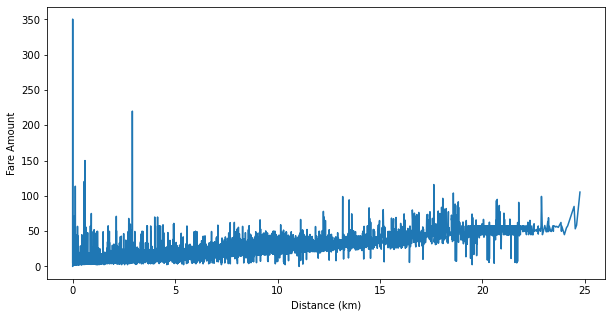

In [46]:
# Plotting ride distance and the fare amount
plt.figure(figsize=(10,5))

# Plot data
plt.plot(sorted_distance_km['Calculated KM'], sorted_distance_km.fare_amount)

# Graph labels
plt.xlabel('Distance (km)')
plt.ylabel('Fare Amount')

As expected, the relation between the distance (km) and the fare amount is consistent until ~24km.

The sorted KM data appears to have a *slighty* better trend against the end fare amount (due to more granularity).
- So we'll go ahead and use the __sorted_distance_km__ dataset.

## Data Processing (Final)

In [47]:
# Our dataset that we're using
sorted_distance_km

,fare_amount,pickup_datetime,passenger_count,pickup_datetime_str,Calculated Miles,Calculated KM
0,5.70,22:07:00,1,22:07:00,0.000000,0.000000
1,11.00,23:14:00,2,23:14:00,0.000000,0.000000
2,8.10,19:28:00,5,19:28:00,0.000000,0.000000
3,10.90,18:01:00,2,18:01:00,0.000000,0.000000
4,6.50,16:41:00,1,16:41:00,0.000000,0.000000
...,...,...,...,...,...,...
49829,57.33,19:26:00,3,19:26:00,15.009663,24.155711
49830,85.00,10:20:00,1,10:20:00,15.205276,24.470520
49831,53.30,04:49:00,6,04:49:00,15.240574,24.527327
49832,58.50,13:32:13,2,13:32:13,15.281431,24.593080


In [48]:
#Let's sort this data by time (asc->desc)
sorted_time_km = sorted_distance_km.sort_values(by='pickup_datetime_str')

# Resetting index
sorted_time_km.reset_index(drop=True, inplace=True)

Text(0, 0.5, 'Fare Amount')

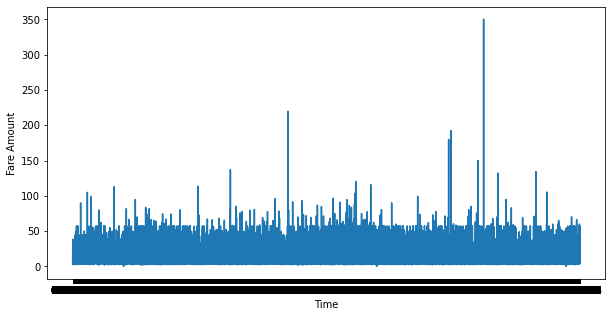

In [49]:
# Plotting passenger count agans fare amount 
plt.figure(figsize=(10,5))

# Plotting data
plt.plot(sorted_time_km.pickup_datetime_str, sorted_time_km.fare_amount)

# Graph labels
plt.xlabel('Time')
plt.ylabel('Fare Amount')

## Model -  prep

In [50]:
# Splitting data into features and target

## Features
x_feats = sorted_distance_km[['Calculated KM']]#, 'pickup_datetime_str']]
    # Add pickup_datetime
    
# Target (Fare Amount)
y_targs = sorted_distance_km[['fare_amount']]

x_feats.tail()

,Calculated KM
49829,24.155711
49830,24.470520
49831,24.527327
49832,24.593080
49833,24.757373


In [67]:
# Splitting data into training and test sets
x_train, x_test, y_train, y_test = train_test_split(x_feats, y_targs, test_size=0.2)

## Model - fitting

In [68]:
# Calling regression model
model = linear_model.LinearRegression()

In [69]:
# Fit regression model
model.fit(x_train, y_train)

LinearRegression()

In [70]:
# Get score of model
model.score(x_test, y_test)

0.7495307637919586

In [71]:
# Predict with rand. value
model.predict([[20]])

array([[49.24383785]])

A 20km ride would cost $49.28

## Model - visualised

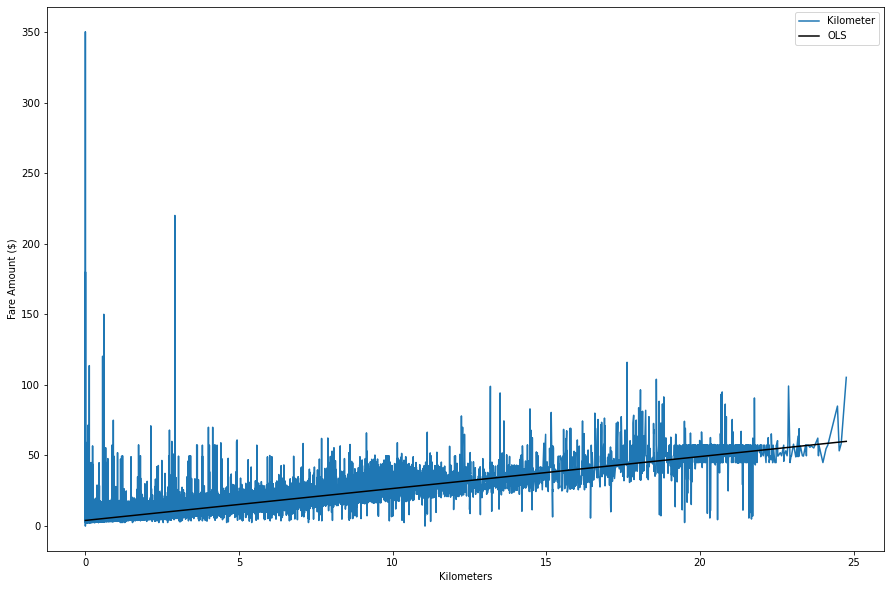

In [72]:
# Plotting LR line against the datapoints
plt.figure(figsize=(15,10))

# Plot data - distance vs. fare
plt.plot(sorted_distance_km['Calculated KM'], sorted_distance_km.fare_amount, label='Kilometer')

# Plot data - OLS line
plt.plot(sorted_distance_km['Calculated KM'], model.predict(x_feats), color='black', label='OLS')

# Set plot labels
plt.xlabel('Kilometers')
plt.ylabel('Fare Amount ($)')

# Show plot labels
plt.legend()